#### 已知 tc 參數出現在 2021/11/24 與 2021/11/30 之間(含)，請用基因演算法來推測非線性 參數 tc, β, ω, Φ，每次計算此基因的 fitness 前，先以線性迴歸推論此基因對應的最佳 A,B,C 參數，並以七個參數計算 p(t0)~p(tc) 序列(合成序列)，最後 fitness 再計算此序列與真實 NVIDIA 股價(真實序列)的差異。請在作業報告中將你求出的最佳參數組合列出，並將合 成序列與直實序列用兩種顏色繪製於同一張折線圖中。

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [35]:
data = pd.read_csv('NVDA.csv')

In [36]:
# tc, beta, w, phi = gene2coef(pop[i, :])
# tc = np.sum(2**np.arange(2)*gene[0:2] + 731)

def F1(t, tc, beta, w, phi, data):
    x = np.zeros((tc, 3))
    b = np.log(data.iloc[0:tc, 4].to_numpy())
    x[:,0] = 1

    for i in range(tc):
        x[i, 1] = (tc-t[i])**beta
        x[i, 2] = ((tc-t[i])**beta)*np.cos(w*np.log(tc-t[i]+phi))
    
    a = np.linalg.lstsq(x, b)[0]
    A = a[0]
    B = a[1]
    C = a[2]/a[1]
    return A, B, C

In [37]:
def F2(t, A, B, C, tc, beta, w, phi):
    return A + B*((tc-t)**beta)*(1 + C*np.cos(w*np.log(tc-t)+phi))

In [38]:
def gene2coef(gene):
    tc = np.sum(2**np.arange(2)*gene[0:2]) + 731
    beta = (np.sum(2**np.arange(10)*gene[2:12])) / 1024
    w = np.sum(2**np.arange(10)*gene[12:22])
    phi = np.sum(2**np.arange(10)*gene[22:32]) / 1024*(2*math.pi)
    return tc, beta, w, phi

In [39]:
T = np.arange(967)
N = 10000
G = 30

survive_rate = 0.05
mutation_rate = 0.001
survive = round(N*survive_rate)
mutation = round(N*40*mutation_rate) # everyone has 40 genes.

In [40]:
# 2 的 5 次方 ＝ 32
# N 列 32 直行
pop = np.random.randint(0, 2, (N, 32))
fit = np.zeros((N, 1))

In [41]:
for generation in range(G):
    for i in range(N):
        tc, beta, w, phi = gene2coef(pop[i, :])
        A, B, C = F1(T, tc, beta, w, phi, data)
        fit[i] = np.mean(abs(F2(T[0:tc], A, B, C, tc, beta, w, phi) - np.log(data.iloc[0:tc, 4].to_numpy())))
    
    sortf = np.argsort(fit[:, 0])
    pop = pop[sortf, :]

    for i in range(survive, N):
        fid = np.random.randint(0, survive)
        mid = np.random.randint(0, survive)

        while(fid == mid):
            mid = np.random.randint(0, survive)
        
        mask = np.random.randint(0, 2, [1, 32])
        son = pop[mid, :].copy()
        father = pop[fid, :]
        son[mask[0, :] == 1] = father[mask[0, :] == 1]
        pop[i, :] = son
    
    for i in range(mutation):
        m = np.random.randint(survive, N)
        n = np.random.randint(0, 32)
        pop[m, n] = 1 - pop[m, n]

/var/folders/8s/csl8f6rj5lbcl3ch8tybntnw0000gn/T/ipykernel_29203/2995487477.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(x, b)[0]


In [42]:
for i in range(N):
    tc, beta, w, phi = gene2coef(pop[i, :])
    A, B, C = F1(T, tc, beta, w, phi, data)
    fit[i] = np.mean(abs(F2(T[0:tc], A, B, C, tc, beta, w, phi) - np.log(data.iloc[0:tc, 4].to_numpy())))

sortf = np.argsort(fit[:, 0])
pop = pop[sortf, :]

/var/folders/8s/csl8f6rj5lbcl3ch8tybntnw0000gn/T/ipykernel_29203/2995487477.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(x, b)[0]


In [43]:
tc2, beta2, w2, phi2 = gene2coef(pop[0, :])
A, B, C = F1(T, tc2, beta2, w2, phi2, data)
tans = F2(T[0:tc2], A, B, C, tc2, beta2, w2, phi2)

/var/folders/8s/csl8f6rj5lbcl3ch8tybntnw0000gn/T/ipykernel_29203/2995487477.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(x, b)[0]


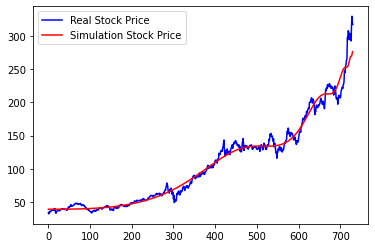

In [48]:
x3 = np.arange(tc2)
y3 = data.iloc[0:tc2, 4].to_numpy()
plt.plot(x3, y3, color = 'blue', label = 'Real Stock Price')
plt.plot(x3, np.exp(tans), color = 'red', label = 'Simulation Stock Price')
plt.legend()
plt.show()

In [45]:
fans = {'variable': ['A', 'B', 'C', 'tc', 'beta', 'w', 'phi'], 'value': [A, B, C, tc2, beta2, w2, phi2]}
fans = pd.DataFrame(fans)
fans

,variable,value
0,A,5.635184
1,B,-0.011262
2,C,0.159584
3,tc,731.000000
4,beta,0.783203
5,w,5.000000
6,phi,0.018408
